In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Generate Training Data

$y = f(x) = \sum_N \big( A\cdot\sin(B \pi) \big)$

For example, we're using $f(x) = \sin(2\pi x) + 1.5\sin(4\pi x) + 0.5\sin(10\pi x)$.

Optionally, we can also add some noise to make the problem slightly more interesting.

Note: we could use $\sum \big( A\cdot\sin(B \pi + C) \big)$ with an added phase value for completeness, but this we can lose the phase for now.

In [2]:
np.random.seed(0)
torch.manual_seed(0)

# Define the target function

# Create an array of x values in [0,1] with predefined number of discrete points
x_np = np.linspace(0, 1, 1000)

# Define the target function with two sinusoidal components
# Optionally, add some noise
# noise = np.random.normal(scale=0.2, size=x_np.shape)
noise = np.zeros_like(x_np)
y_np = np.sin(2 * np.pi * x_np) + 1.5 * np.sin(4 * np.pi * x_np) + 0.5 * np.sin(10 * np.pi * x_np) + noise

# Convert to torch tensors (each as column vectors)
x_tensor = torch.tensor(x_np, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y_np, dtype=torch.float32).unsqueeze(1)

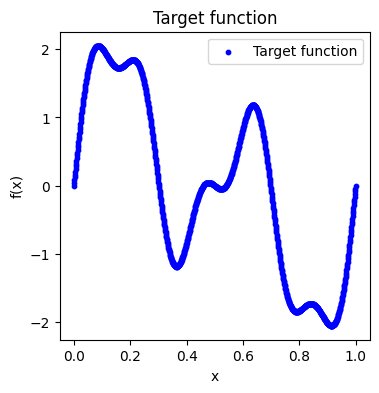

In [114]:
# Plot Ground Truth Data
fig, ax = plt.subplots(figsize=(4, 4))
plt.title("Target function")

# Plot the target function as scatter points
ax.scatter(x_np, y_np, s=10, label='Target function', color='blue')

ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('f(x)');

# Option 1: Supervised NN with Limited Capacity

2 hidden layers, with 10 neurons each (and ReLU activations).

Total **number of parameters** (weights and biases) $= 141$.

In [31]:
# Define a simple MLP with two hidden layers.
class MLP(nn.Module):
    def __init__(self, N: int):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, N),
            nn.ReLU(),
            nn.Linear(N, N),
            nn.ReLU(),
            nn.Linear(N, 1)
        )
        self._init_weights()
    
    def _init_weights(self):
        # Apply Kaiming normal initialization for layers with ReLU activation.
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Kaiming initialization works well with ReLU activations.
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.net(x)

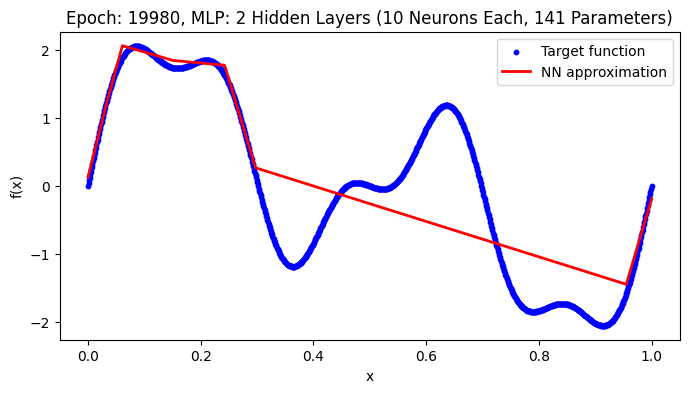

In [103]:
model_10 = MLP(10) # 2 hidden layers with 10 neurons each
criterion = nn.MSELoss()
optimizer = optim.Adam(model_10.parameters(), lr=0.01)

# Parameters for training and recording
epochs = 20000
record_every = 20   # record the predictions every R epochs
frames = []        # to store network predictions for animation

# Training loop with recording of predictions
for epoch in range(epochs):
    model_10.train()
    optimizer.zero_grad()
    output = model_10(x_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

    # Record predictions every `record_every` epochs for animation
    if epoch % record_every == 0:
        model_10.eval()
        with torch.no_grad():
            preds = model_10(x_tensor).numpy().flatten()
        frames.append((epoch, preds.copy()))  # frames[i] = [epoch, preds]

# Plot final state and make it ready for animation
fig, ax = plt.subplots(figsize=(8, 4))
# Plot the target function as scatter points
ax.scatter(x_np, y_np, s=10, label='Target function', color='blue')
# Initialize a line for animating the network's prediction through the epochs below
[line] = ax.plot(x_np, frames[-1][1], color='red', lw=2, label='NN approximation')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title(f"Epoch: {frames[-1][0]}, MLP: 2 Hidden Layers (10 Neurons Each, 141 Parameters)");

In [104]:
# Update function for the animation
def update(frame_info):
    epoch, pred = frame_info
    line.set_ydata(pred)
    ax.set_title(f"Epoch: {epoch}, MLP: 2 Hidden Layers (10 Neurons Each, 141 Parameters)")
    return line,

# Create the animation (interval is in milliseconds)
ani = animation.FuncAnimation(fig, update, frames=frames, interval=10, blit=True)

# Save the animation in a video file.
# Note: it's normal for this to take >1 minute or so based on number of epochs and saving frequency
ani.save('tiny_sindy/mlp_fitting_low_capacity.mp4', writer='ffmpeg')

# Option 2: Supervised NN with More Capacity

2 hidden layers, with 50 neurons each (and ReLU activations).

Total **number of parameters** (weights and biases) $= 2701$.

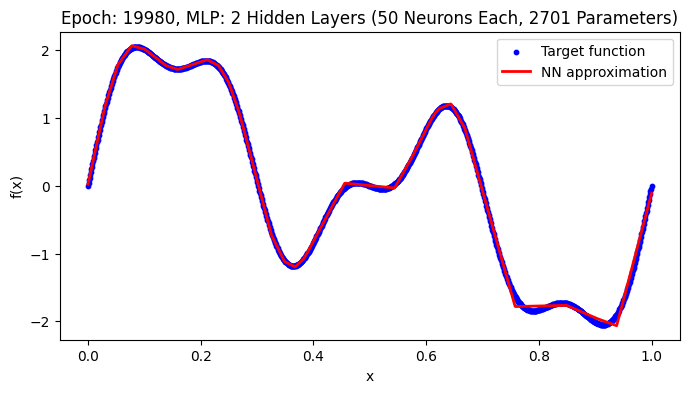

In [105]:
model_50 = MLP(50)  # 2 hidden layers, with 50 neurons each
criterion = nn.MSELoss()
optimizer = optim.Adam(model_50.parameters(), lr=0.01)

# Parameters for training and recording
epochs = 20000
record_every = 20   # record the predictions every R epochs
frames = []        # to store network predictions for animation

# Training loop with recording of predictions
for epoch in range(epochs):
    model_50.train()
    optimizer.zero_grad()
    output = model_50(x_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

    # Record predictions every `record_every` epochs for animation
    if epoch % record_every == 0:
        model_50.eval()
        with torch.no_grad():
            preds = model_50(x_tensor).numpy().flatten()
        frames.append((epoch, preds.copy()))  # frames[i] = [epoch, preds]
        
# Plot final state and make it ready for animation
fig, ax = plt.subplots(figsize=(8, 4))
# Plot the target function as scatter points
ax.scatter(x_np, y_np, s=10, label='Target function', color='blue')
# Initialize a line for animating the network's prediction through the epochs below
[line] = ax.plot(x_np, frames[-1][1], color='red', lw=2, label='NN approximation')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title(f"Epoch: {frames[-1][0]}, MLP: 2 Hidden Layers (50 Neurons Each, 2701 Parameters)");

In [106]:
# Update function for the animation
def update(frame_info):
    epoch, pred = frame_info
    line.set_ydata(pred)
    ax.set_title(f"Epoch: {epoch}, MLP: 2 Hidden Layers (50 Neurons Each, 2701 Parameters)")
    return line,

# Create the animation (interval is in milliseconds)
ani = animation.FuncAnimation(fig, update, frames=frames, interval=10, blit=True)

# Save the animation in a video file.
# Note: it's normal for this to take >1 minute or so based on number of epochs and saving frequency
ani.save('tiny_sindy/mlp_fitting_high_capacity.mp4', writer='ffmpeg')

# Option 3: Sinusoidal Model

Running the optimization with only e.g. 3 sine waves (same number as ground truth data) gets stuck in local minima very often. Initializing with N=100 or something similar seems to get rid of this problem.

Inspired by SINDy, we can enforce sparsity in the parameters by further adding in an $L_1$-loss for regularization.

$
\text{Loss}(y_{pred}, \hat{y}, \theta) 
= \underbrace{
    ||y_{pred} - \hat{y}||_2^2}_{\text{data loss}
} + \underbrace{
    |\theta_{A}|
}_{
    \text{sparsity loss}
}$

In [39]:
# Define a "physically-inspired" model that directly optimizes amplitude (A) and frequency (B) of sinusoids
class SinusoidModel(nn.Module):
    def __init__(self, n_sines=3):
        super(SinusoidModel, self).__init__()
        self.n_sines = n_sines
        # Directly optimize amplitudes and frequencies.
        # Initialize amplitudes with small values.
        self.A = nn.Parameter(torch.randn(1, n_sines) * 0.1)
        self.B = nn.Parameter(torch.randn(1, n_sines))

    def forward(self, x):
        # Not: ensuring amplitudes to remain positive seems to reduce convergence.
        # A = torch.nn.functional.softplus(self.A)
        A = self.A
        # Constrain frequencies to a plausible range (e.g., [0, 12π]).
        B = 20 * np.pi * torch.sigmoid(self.B)

        # The phase is not optimized, we assume phase = 0.
        # Compute each sinusoid: f_i(x) = A_i * sin(B_i * x)
        x_expanded = x.expand(-1, self.n_sines)
        f_components = A * torch.sin(B * x_expanded)
        f_sum = torch.sum(f_components, dim=1, keepdim=True)
        return f_sum, {'A': A.detach().cpu().numpy().flatten(),
                       'B': B.detach().cpu().numpy().flatten()}

In [124]:
# Set up training of sinusoidal network
N_sines = 50
model = SinusoidModel(n_sines=N_sines)
l2_loss = nn.MSELoss()
sparsity_lambda = 0.01  # Increase this to enforce sparsity
optimizer = optim.Adam([
    {'params': model.A, 'lr': 0.005},  # amplitudes can often tolerate a higher lr
    {'params': model.B, 'lr': 0.001},  # frequencies are more sensitive
])

epochs = 10000
record_every = 4  # Record every R epochs
frames = []       # To store (epoch, predictions, parameter snapshots)

# Training
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    preds, _ = model(x_tensor)
    curr_mse_loss = l2_loss(preds, y_tensor)
    if sparsity_lambda > 0:
        # L1 penalty on amplitude parameters (A)
        l1_loss = sparsity_lambda * torch.norm(model.A, 1) + sparsity_lambda * torch.norm(model.B, 1)
        # Total loss combines MSE and L1 sparsity penalty
        loss = curr_mse_loss + l1_loss
    else:
        # No param regularization term
        loss = curr_mse_loss

    loss.backward()
    optimizer.step()

    # Record every record_every epochs
    if epoch % record_every == 0:
        model.eval()
        with torch.no_grad():
            preds, params = model(x_tensor)
            preds_np = preds.numpy().flatten()
        frames.append((epoch, preds_np.copy(), params))

In [125]:
preds, _ = model(x_tensor)
loss = criterion(preds, y_tensor)
print(f"Final Loss: {loss.item()}")

Final Loss: 0.00011405791155993938


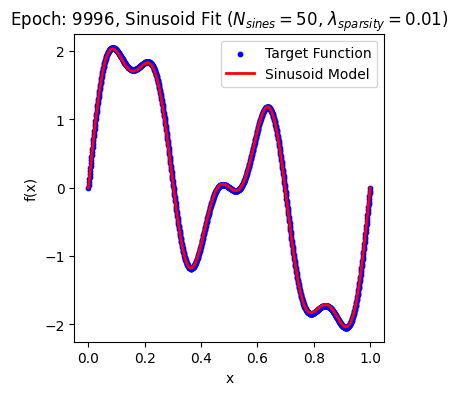

In [126]:
# Set up an Animation of the Fitting Process
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x_np, y_np, s=10, label='Target Function', color='blue')
[line] = ax.plot(x_np, frames[-1][1], color='red', lw=2, label=f'Sinusoid Model')

ax.set_title(f"Epoch: {frames[-1][0]}, Sinusoid Fit ($N_{{sines}}={N_sines}$, $λ_{{sparsity}}=${sparsity_lambda})")
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('f(x)');

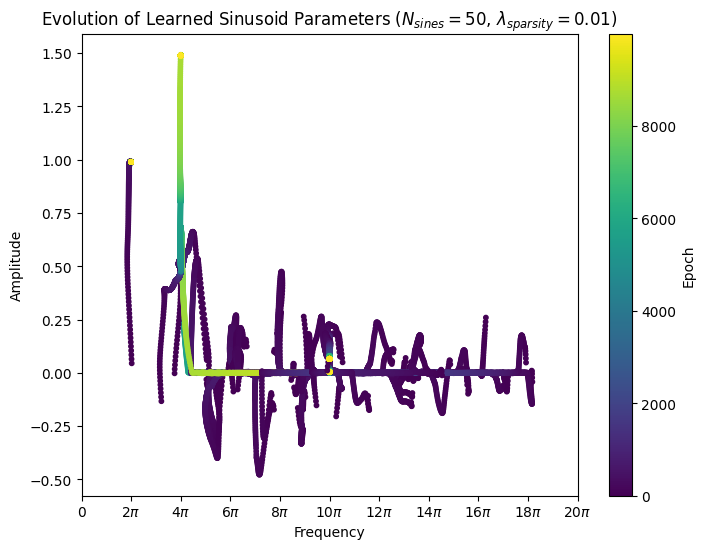

In [127]:
# Assume frames is defined and populated during training.
# Each element in frames is: (epoch, preds, params) where
# params = {'A': array([...]), 'B': array([...])}
n_sines = len(frames[0][2]['A'])

# Create lists to store the evolution of each sinusoid's parameters
amps = [[] for _ in range(n_sines)]
freqs = [[] for _ in range(n_sines)]
epochs_list = [[] for _ in range(n_sines)]

# Extract parameters for each sinusoid across all recorded frames
for epoch, _, params in frames:
    for i in range(n_sines):
        amps[i].append(params['A'][i])
        freqs[i].append(params['B'][i])
        epochs_list[i].append(epoch)

plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, n_sines))

# Plot each sinusoid's parameter evolution with a different color
for i in range(n_sines):
    sc = plt.scatter(freqs[i], amps[i], c=epochs_list[i], cmap='viridis', label=f'Sinusoid {i+1}', s=10)

plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title(f'Evolution of Learned Sinusoid Parameters ($N_{{sines}}={N_sines}$, $λ_{{sparsity}}=${sparsity_lambda})')

# Define tick locations from 0 to 20π in steps of π.
ticks = np.pi * np.arange(0, 21, 2)
tick_labels = [r"$0$" if i == 0 else r"$%d\pi$" % i for i in range(0, 21, 2)]
plt.xticks(ticks, tick_labels)

plt.colorbar(sc, label='Epoch')
#plt.legend()
plt.show()

### Plot and Animate Inference and Parameter Distribution at the Same Time

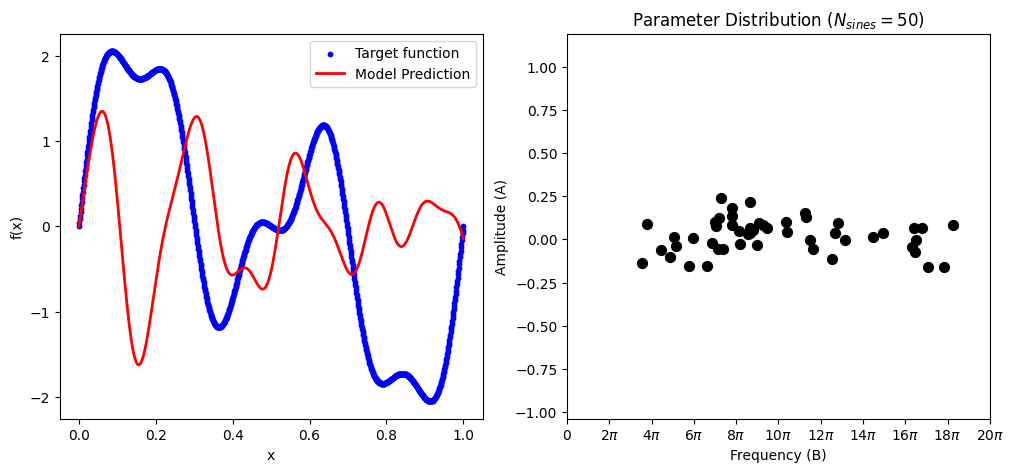

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left subplot: plot the target function and initialize the prediction line.
ax1.scatter(x_np, y_np, s=10, color='blue', label='Target function')
line, = ax1.plot(x_np, frames[0][1], color='red', lw=2, label='Model Prediction')
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.legend()

# Right subplot: parameter distribution plot.
ax2.set_xlabel('Frequency (B)')
ax2.set_ylabel('Amplitude (A)')
ax2.set_title(f'Parameter Distribution ($N_{{sines}}={N_sines}$)')#, $λ_{{sparsity}}=${sparsity_lambda})')
# Set x-axis ticks in increments of π. Here we assume frequencies up to 20π.
ticks = np.pi * np.arange(0, 21, 2)
tick_labels = [r"$0$" if i == 0 else r"$%d\pi$" % i for i in range(0, 21, 2)]
ax2.set_xticks(ticks)
ax2.set_xticklabels(tick_labels)
ax2.set_xlim([0, ticks[-1]])

# Compute new y-limits based on current amplitudes with a margin.
all_A = np.array([f[2]["A"] for f in frames])
y_min, y_max = np.min(all_A), np.max(all_A)
margin = 0.1 * (y_max - y_min) if (y_max - y_min) != 0 else 0.1
ax2.set_ylim(y_min - margin, y_max + margin)

# Initialize scatter plot on ax2 with parameters from the first frame.
initial_params = frames[0][2]
initial_offsets = np.column_stack((initial_params['B'], initial_params['A']))
scatter = ax2.scatter(initial_offsets[:, 0], initial_offsets[:, 1], color='black', s=50)

In [123]:
def update(frame_info):
    epoch, pred, curr_params = frame_info

    # Update the left plot (prediction line)
    line.set_ydata(pred)
    ax1.set_title(f"Epoch: {epoch}, Sinusoid Model")

    # Update the right plot (parameter distribution)
    A = curr_params['A']
    B = curr_params['B']
    offsets = np.column_stack((B, A))
    scatter.set_offsets(offsets)
    
    return line, scatter

# Create the animation.
ani = animation.FuncAnimation(fig, update, frames=frames, interval=10, blit=True)

# Save the animation. (Note: saving might take >1 minute based on frame count and settings)
ani.save('tiny_sindy/sinusoidal_with_params_no_sparsity.mp4', writer='ffmpeg', fps=30)
plt.show()